In [1]:
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "07_training/07b_gpumax.ipynb"
_nb_title = "GPU utilization"

### no need to change any of this
_nb_safeloc = _nb_loc.replace('/', '%2F')
md("""
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name={1}&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F{2}&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F{2}">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
""".format(_nb_loc, _nb_title, _nb_safeloc))


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=GPU utilization&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F07_training%2F07b_gpumax.ipynb&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F07_training%2F07b_gpumax.ipynb">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/07_training/07b_gpumax.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/07_training/07b_gpumax.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/07_training/07b_gpumax.ipynb">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


# GPU Utilization

In this notebook, we show how to take advantage of TensorFlow optimizations for the GPU.

## Enable GPU and set up helper functions

This notebook and pretty much every other notebook in this repository
will run faster if you are using a GPU.
On Colab:
- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
- Navigate to https://console.cloud.google.com/ai-platform/notebooks
- Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
import tensorflow as tf
print('TensorFlow version' + tf.version.VERSION)
print('Built with GPU support? ' + ('Yes!' if tf.test.is_built_with_cuda() else 'Noooo!'))
print('There are {} GPUs'.format(len(tf.config.experimental.list_physical_devices("GPU"))))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

## Ingest code

In [1]:
%%writefile input.txt
gs://practical-ml-vision-book-data/images/california_fire1.jpg
gs://practical-ml-vision-book-data/images/california_fire2.jpg

Overwriting input.txt


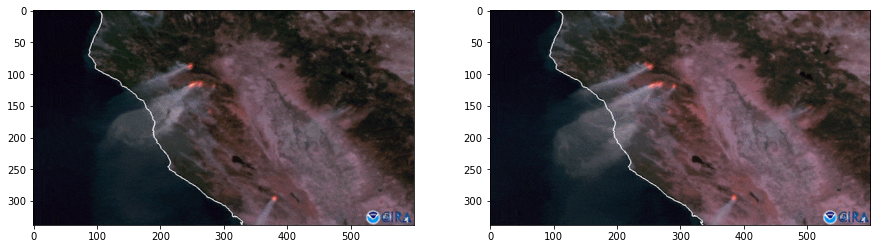

In [2]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

def read_jpeg(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.reshape(img, [338, 600, 3])
    return img

ds = tf.data.TextLineDataset('input.txt').map(read_jpeg)
f, ax = plt.subplots(1, 2, figsize=(15,10))
for idx, img in enumerate(ds):
    ax[idx].imshow( img.numpy() );

## Adding a map function

Let's say that we want to apply a custom formula to convert the images.

(338, 600)


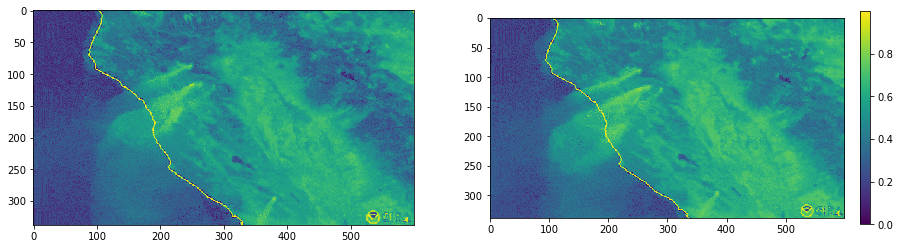

In [3]:
def to_grayscale(img):
    red = img[:, :, 0]
    green = img[:, :, 1]
    blue = img[:, :, 2]
    c_linear = 0.2126 * red + 0.7152 * green + 0.0722 * blue
    gray = tf.where(c_linear > 0.0031308,
                    1.055 * tf.pow(c_linear, 1/2.4) - 0.055,
                    12.92*c_linear)
    print(gray.shape)
    return gray

ds = tf.data.TextLineDataset('input.txt').map(read_jpeg).map(to_grayscale)
f, ax = plt.subplots(1, 2, figsize=(15,10))
for idx, img in enumerate(ds):
    im = ax[idx].imshow( img.numpy() , interpolation='none');
    if idx == 1:
        f.colorbar(im, fraction=0.028, pad=0.04)

### 1. Iterating through image

(don't do this)

In [4]:
# This function is not accelerated. At all.
def to_grayscale(img):
    rows, cols, _ = img.shape
    result = np.zeros([rows, cols], dtype=np.float32)
    for row in range(rows):
        for col in range(cols):
            red = img[row][col][0]
            green = img[row][col][1]
            blue = img[row][col][2]
            c_linear = 0.2126 * red + 0.7152 * green + 0.0722 * blue
            if c_linear > 0.0031308:
                result[row][col] = 1.055 * pow(c_linear, 1/2.4) - 0.055
            else:
                result[row][col] = 12.92*c_linear
    return result

In [5]:
%%time
ds = tf.data.TextLineDataset('input.txt').repeat(10).map(read_jpeg)

overall = tf.constant([0.], dtype=tf.float32)
count = 0
for img in ds:
    # Notice that we have to call .numpy() to move the data outside TF Graph
    gray = to_grayscale(img.numpy())
    # This moves the data back into the graph
    m = tf.reduce_mean(gray, axis=[0, 1])
    overall += m
    count += 1
print(overall/count)

tf.Tensor([0.46331078], shape=(1,), dtype=float32)
CPU times: user 39.3 s, sys: 353 ms, total: 39.6 s
Wall time: 41.1 s


### 2. Pyfunc

If you absolutely need to iterate or call Python-only
functionality (like time/json/etc.) and still need to use map(),
you can use a py_func

Data is still moved out of the graph, the job done, and data moved back into
the graph. So, efficiency-wise it's not a gain.

In [6]:
def to_grayscale_numpy(img):
    # the numpy happens here
    img = img.numpy()
    rows, cols, _ = img.shape
    result = np.zeros([rows, cols], dtype=np.float32)
    for row in range(rows):
        for col in range(cols):
            red = img[row][col][0]
            green = img[row][col][1]
            blue = img[row][col][2]
            c_linear = 0.2126 * red + 0.7152 * green + 0.0722 * blue
            if c_linear > 0.0031308:
                result[row][col] = 1.055 * pow(c_linear, 1/2.4) - 0.055
            else:
                result[row][col] = 12.92*c_linear
    # the convert back happens here
    return tf.convert_to_tensor(result)

def to_grayscale(img):
    return tf.py_function(to_grayscale_numpy, [img], tf.float32)

In [7]:
%%time
ds = tf.data.TextLineDataset('input.txt').repeat(10).map(read_jpeg).map(to_grayscale)

overall = tf.constant([0.], dtype=tf.float32)
count = 0
for gray in ds:
    m = tf.reduce_mean(gray, axis=[0, 1])
    overall += m
    count += 1
print(overall/count)

tf.Tensor([0.46331078], shape=(1,), dtype=float32)
CPU times: user 39.4 s, sys: 308 ms, total: 39.7 s
Wall time: 41.1 s


### 3. Use TensorFlow slicing and tf.where

This is 10x faster than iterating.

In [8]:
# All in GPU
def to_grayscale(img):
    # TensorFlow slicing functionality
    red = img[:, :, 0]
    green = img[:, :, 1]
    blue = img[:, :, 2]
    # All these are actually tf.mul(), tf.add(), etc.
    c_linear = 0.2126 * red + 0.7152 * green + 0.0722 * blue
    # Use tf.cond and tf.where for if-then statements
    gray = tf.where(c_linear > 0.0031308,
                    1.055 * tf.pow(c_linear, 1/2.4) - 0.055,
                    12.92*c_linear)
    return gray

In [9]:
%%time
ds = tf.data.TextLineDataset('input.txt').repeat(10).map(read_jpeg).map(to_grayscale)

overall = tf.constant([0.])
count = 0
for gray in ds:
    m = tf.reduce_mean(gray, axis=[0, 1])
    overall += m
    count += 1
print(overall/count)

tf.Tensor([0.46331078], shape=(1,), dtype=float32)
CPU times: user 2.6 s, sys: 1.84 s, total: 4.44 s
Wall time: 3.07 s


### 4. Use Matrix math and tf.where

This is 3x as fast as the slicing.

In [10]:
def to_grayscale(img):
    wt = tf.constant([[0.2126], [0.7152], [0.0722]]) # 3x1 matrix
    c_linear = tf.matmul(img, wt) # (ht,wd,3) x (3x1) -> (ht, wd)
    gray = tf.where(c_linear > 0.0031308,
                    1.055 * tf.pow(c_linear, 1/2.4) - 0.055,
                    12.92*c_linear)
    return gray

In [11]:
%%time
ds = tf.data.TextLineDataset('input.txt').repeat(10).map(read_jpeg).map(to_grayscale)

overall = tf.constant([0.])
count = 0
for gray in ds:
    m = tf.reduce_mean(gray, axis=[0, 1])
    overall += m
    count += 1
print(overall/count)

tf.Tensor([0.46331078], shape=(1,), dtype=float32)
CPU times: user 870 ms, sys: 349 ms, total: 1.22 s
Wall time: 2.29 s


### 5. Batching

Fully vectorize the operations so that they work on a batch of images

In [12]:
class Grayscale(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Grayscale, self).__init__(kwargs)
    
    def call(self, img):
        wt = tf.constant([[0.2126], [0.7152], [0.0722]]) # 3x1 matrix
        c_linear = tf.matmul(img, wt) # (N, ht,wd,3) x (3x1) -> (N, ht, wd)
        gray = tf.where(c_linear > 0.0031308,
                        1.055 * tf.pow(c_linear, 1/2.4) - 0.055,
                        12.92*c_linear)
        return gray # (N, ht, wd)

model = tf.keras.Sequential([
    Grayscale(input_shape=(336, 600, 3)),
    tf.keras.layers.Lambda(lambda gray: tf.reduce_mean(gray, axis=[1, 2])) # note axis change
])

In [13]:
%%time
ds = tf.data.TextLineDataset('input.txt').repeat(10).map(read_jpeg).batch(5)
overall = tf.constant([0.])
count = 0
for batch in ds:
    bm = model(batch)
    overall += tf.reduce_sum(bm)
    count += len(bm)
print(overall/count)

tf.Tensor([0.4633108], shape=(1,), dtype=float32)
CPU times: user 770 ms, sys: 339 ms, total: 1.11 s
Wall time: 2.13 s


## Results

When we did it, these were the timings we got:

| Method                 | CPU time    | Wall time    |
| ---------------------- | ----------- | ------------ |
| Iterate                | 39.6s       | 41.1s        |
| Pyfunc                 | 39.7s       | 41.1s        |
| Slicing                | 4.44s       | 3.07s        |
| Matmul                 | 1.22s       | 2.29s        |
| Batch                  | 1.11s       | 2.13s        |

## Signature

Playing around with signature

In [31]:
from inspect import signature

def myfunc(a, b):
    return (a + b)

print(myfunc(3,5))
print(myfunc('foo', 'bar'))
print(signature(myfunc).parameters)
print(signature(myfunc).return_annotation)

8
foobar
OrderedDict([('a', <Parameter "a">), ('b', <Parameter "b">)])
<class 'inspect._empty'>


In [32]:
from inspect import signature

def myfunc(a: int, b: float) -> float:
    return (a + b)

print(myfunc(3,5))
print(myfunc('foo', 'bar')) # runtime doesn't check
print(signature(myfunc).parameters)
print(signature(myfunc).return_annotation)

8
foobar
OrderedDict([('a', <Parameter "a: int">), ('b', <Parameter "b: float">)])
<class 'float'>


In [26]:
from inspect import signature
import tensorflow as tf

@tf.function(input_signature=[
    tf.TensorSpec([3,5], name='a'),
    tf.TensorSpec([5,8], name='b')
])
def myfunc(a, b):
    return (tf.matmul(a,b))

print(myfunc.get_concrete_function(tf.ones((3,5)), tf.ones((5,8))))

ConcreteFunction myfunc(a, b)
  Args:
    a: float32 Tensor, shape=(3, 5)
    b: float32 Tensor, shape=(5, 8)
  Returns:
    float32 Tensor, shape=(3, 8)


## License
Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.